In [8]:
import os
import torch
import numpy as np
import timm
from datasets import load_dataset
torch.cuda.empty_cache()

import matplotlib.pyplot as plt
from PIL import ImageDraw
from PIL import ImageFont
import cv2

# selection: you can select multiple but consider the memory
selected_dataset = {#'Oxford-IIIT-Pets': 'jonathancui/oxford-pets',
                     #'Oxford-Flowers-102': 'nelorth/oxford-flowers',
                     'CIFAR-10': 'cifar10',
                     #'CIFAR-100': 'cifar100',
                     #'ImageNet': 'imagenet-1k',
                     # 'ImageNetReaL': 'imagenet-1k',
} # couldn't find VTAB

dataset_title = [*selected_dataset.keys()][0]
selected_dataset = selected_dataset[dataset_title]

selected_model = {
                   #'ViT-L-16': 'vit_large_patch16_224.augreg_in21k',
                   #'ViT-L-16-FT': 'vit_large_patch16_224.augreg_in21k_ft_in1k',
                   'EfficientNet-L2': 'tf_efficientnetv2_l.in21k',
                   #'ViT-H-14': 'vit_huge_patch14_224_in21k',
                   #'BiT-L-ResNet152x4': 'resnetv2_152x4_bit.goog_in21k',
                   
}
model_title = [*selected_model.keys()][0]
selected_model = selected_model[model_title]

print(f'Inferencing: {selected_model}-{selected_dataset} ...')
dataset = load_dataset(selected_dataset)
key = [*dataset['train'].features.keys()][-1]
if selected_dataset == 'ImageNet':
    model = timm.create_model(selected_model, pretrained=True)
    model.to('cuda:0')
    model.requires_grad_(False)
    model = torch.nn.DataParallel(model, device_ids=[0])
else:
    model = timm.create_model(selected_model, pretrained=True, num_classes=len(dataset['train'].features[key].names))
    model.to('cuda:0')
    model.requires_grad_(False)
    model = torch.nn.DataParallel(model, device_ids=[0])
    model.load_state_dict(torch.load(f'{model_title}-{dataset_title}.pt'))
model_configs = timm.data.resolve_data_config(model=model)
data_transform = timm.data.create_transform(**model_configs)


Inferencing: tf_efficientnetv2_l.in21k-cifar10 ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


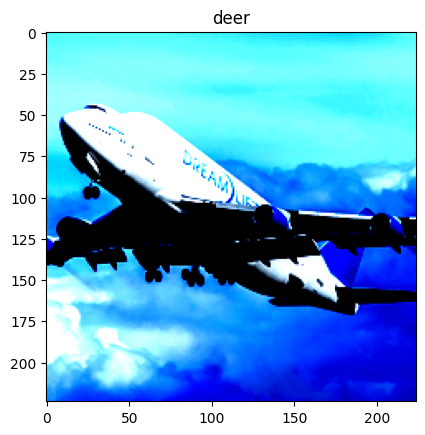

In [15]:
ImagePath = 'test_imgs/plane.jpg'
# inference on a single image
from PIL import Image
from torchvision import transforms
orig_image = Image.open(ImagePath)
img = data_transform(orig_image)
img = img.unsqueeze(0)
img = img.to('cuda')
model.eval()
output = model(img)
_, pred = torch.max(output, 1)
categories = dataset['train'].features[key].names
obj_class = categories[pred.item()]
draw = ImageDraw.Draw(orig_image)
font_path = os.path.join(cv2.__path__[0],'qt','fonts','DejaVuSans.ttf')
font = ImageFont.truetype(font_path, size=32)
draw.text((0, 0), obj_class, (255, 0, 0), font=font)
img = data_transform(orig_image)
img = img.unsqueeze(0)
img = img.to('cuda')

# show image and prediction
plt.imshow(img.squeeze().cpu().numpy().transpose(1,2,0))
plt.title(obj_class)
plt.show()